In [61]:
import numpy as np 
import pandas as pd 
import xarray as xr 
from matplotlib import pyplot as plt 
import glob
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib import colors, cm
from matplotlib.colors import Normalize
import scipy.io as sio
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


class MidpointNormalize(Normalize):
    """Normalise the colorbar.  e.g. norm=MidpointNormalize(mymin, mymax, 0.)"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
    #get viridis colormaps
def cmap_codes(name, number):
    cmap = cm.get_cmap(name, number) 
    hexcodes = []
    for i in range(cmap.N): 
        hexcodes.append(colors.rgb2hex(cmap(i)[:3]))
    return hexcodes

In [81]:
names_6g

['/Users/rogercreel/Desktop/readv_output_020320/d6g_h6g_12000_500_modelaverage_fennoscandia_giaprior',
 '/Users/rogercreel/Desktop/readv_output_020320/d6g_h6g_12000_500_modelaverage_fennoscandia_loglikelihood',
 '/Users/rogercreel/Desktop/readv_output_020320/d6g_h6g_12000_500_modelaverage_fennoscandia_gpvariance',
 '/Users/rogercreel/Desktop/readv_output_020320/d6g_h6g_12000_500_modelaverage_fennoscandia_dazp',
 '/Users/rogercreel/Desktop/readv_output_020320/d6g_h6g_12000_500_modelaverage_fennoscandia_posterior']

In [86]:
path = '/Users/rogercreel/Desktop/readv_output_020320/'

names_glac = glob.glob(path + 'glac*modelaverage*')
names_6g = glob.glob(path + 'd6g*modelaverage*')

def process(name):
    
    ds = xr.open_dataset(name)
    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
    except:
        pass
    try:
        ds = ds.drop('scale')
    except:
        pass
    return ds


ds_glaczp = process(names_glac[0])
ds_glacpost = process(names_glac[1])
ds_glacprior = process(names_glac[2])
ds_glacvar = process(names_glac[4])

ds_6gprior = process(names_6g[0])
ds_6gvar = process(names_6g[2])
ds_6gzp = process(names_6g[3])
ds_6gpost = process(names_6g[4])




In [89]:
ds_6gpost.rsl

<xarray.DataArray 'rsl' (age: 116, lat: 70, lon: 70)>
[568400 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -11.95 -11.09 -10.24 -9.382 ... 45.4 46.25 47.11
  * lat      (lat) float64 43.86 44.26 44.65 45.05 ... 70.04 70.44 70.83 71.23
  * age      (age) int64 12000 11900 11800 11700 11600 ... 900 800 700 600 500

# Load GIA models to take STD

In [91]:
def build_dataset(path, model):
    """download model runs from local directory."""
    path = path
    files = f'{path}*.nc'
    basefiles = glob.glob(files)
    modelrun = [
        key.split('output_', 1)[1][:-3].replace('.', '_')
        for key in basefiles
    ]
    dss = xr.open_mfdataset(files,
                            chunks=None,
                            concat_dim='modelrun',
                            combine='nested')
    lats, lons, times = dss.LAT.values[0], dss.LON.values[
        0], dss.TIME.values[0]
    ds = dss.drop(['LAT', 'LON', 'TIME'])
    ds = ds.assign_coords(lat=lats,
                          lon=lons,
                          time=times,
                          modelrun=modelrun).rename({
                              'time': 'age',
                              'RSL': 'rsl'
                          })
    return ds

def one_mod(path, names):
    """Organize model runs into xarray dataset."""
    ds1 = build_dataset(path, names[0])
    names = names[1:]
    ds = ds1.chunk({'lat': 10, 'lon': 10})
    for i in range(len(names)):
        temp = build_dataset(names[i])
        temp1 = temp.interp_like(ds1)
        temp1['modelrun'] = temp['modelrun']
        ds = xr.concat([ds, temp1], dim='modelrun')
    ds['age'] = ds['age'] * 1000
    ds = ds.roll(lon=256, roll_coords=True)
    ds.coords['lon'] = pd.DataFrame((ds.lon[ds.lon >= 180] - 360)- 0.12 ) \
                            .append(pd.DataFrame(ds.lon[ds.lon < 180]) + 0.58) \
                            .reset_index(drop=True).squeeze()
    ds.coords['lat'] = ds.lat[::-1]
    ds = ds.swap_dims({'dim_0': 'lon'}).drop('dim_0')
    return ds


#make stds of each ice model
path = f'data/glac1d_/output_{model}'
ds = one_mod(path, [model])
ds_glacsliced = ds.rsl.sel(age=slice(tmax, tmin),
                       lon=slice(df_place.lon.min() - 2,
                                 df_place.lon.max() + 2),
                       lat=slice(df_place.lat.min() - 2,
                                 df_place.lat.max() + 2))

ds_glacstd = ds_sliced.std(dim='modelrun').load().to_dataset().interp(
    age=ds_readv.age, lon=ds_readv.lon, lat=ds_readv.lat)

path = f'data/d6g_h6g_/output_{model}'
ds = one_mod(path, [model])
ds_6gsliced = ds.rsl.sel(age=slice(tmax, tmin),
                       lon=slice(df_place.lon.min() - 2,
                                 df_place.lon.max() + 2),
                       lat=slice(df_place.lat.min() - 2,
                                 df_place.lat.max() + 2))

ds_6gstd = ds_sliced.std(dim='modelrun').load().to_dataset().interp(
    age=ds_readv.age, lon=ds_readv.lon, lat=ds_readv.lat)

NameError: name 'model' is not defined

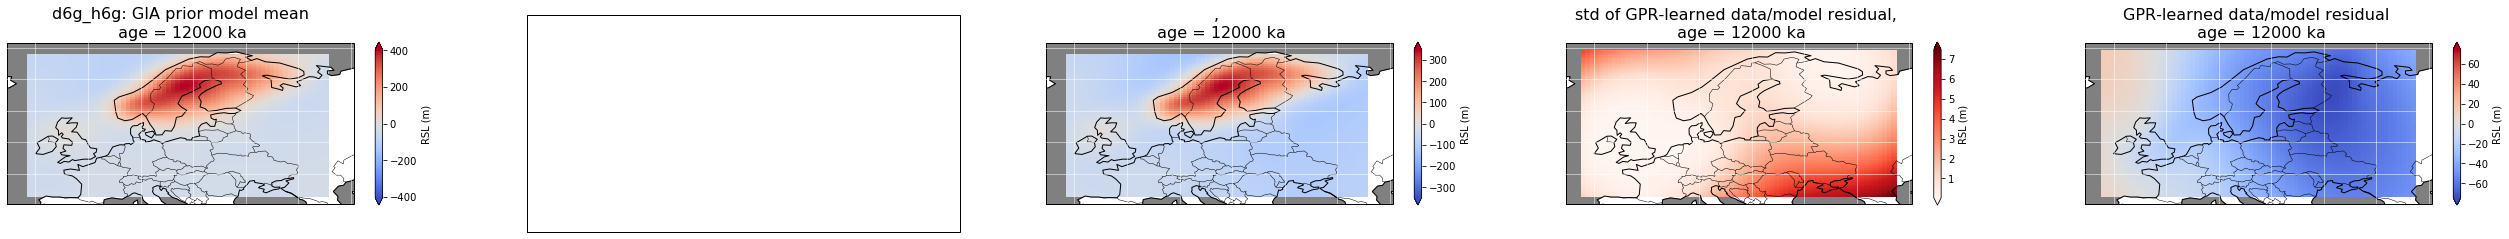

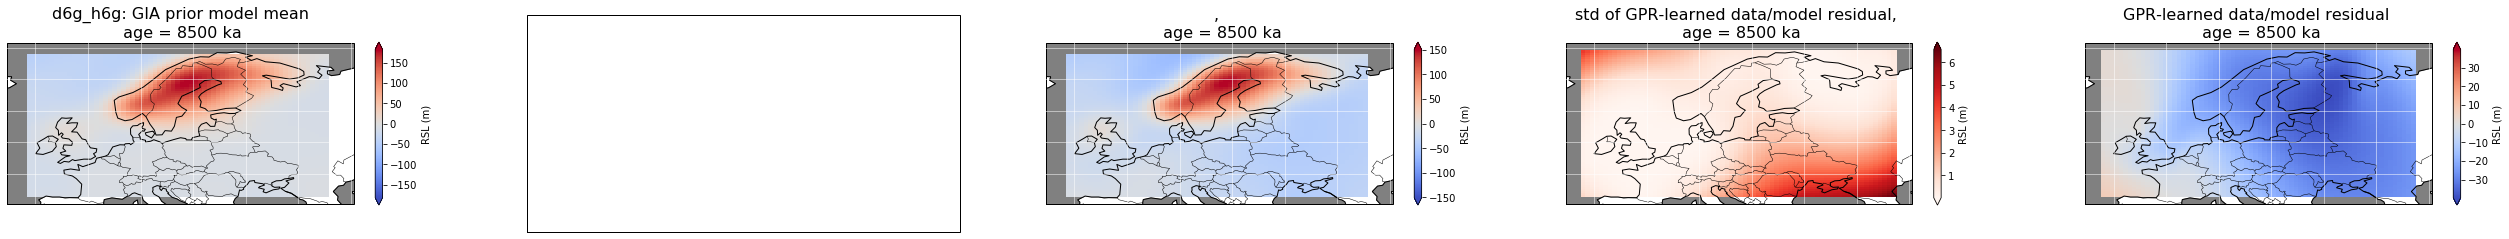

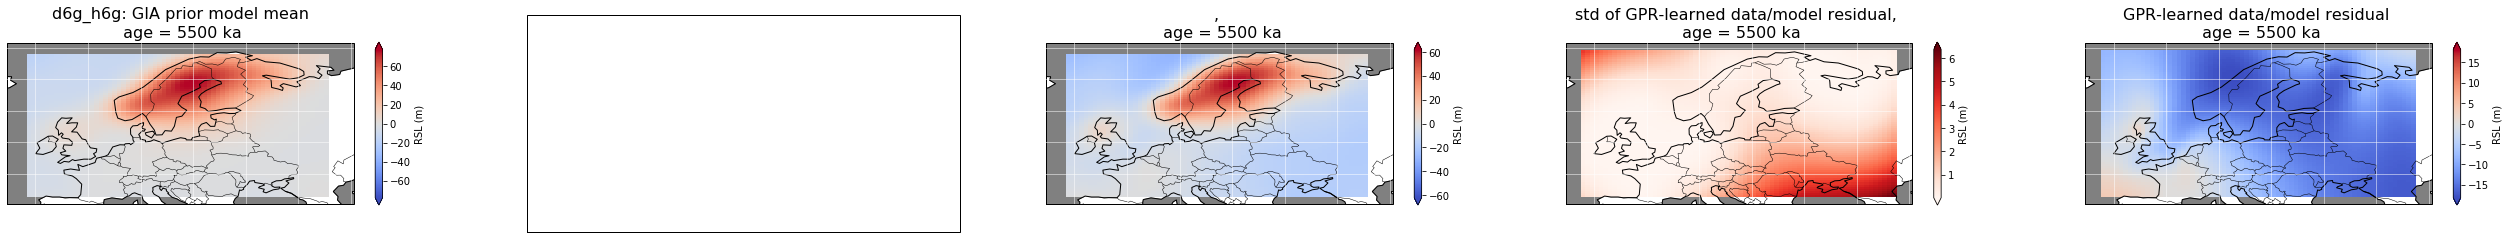

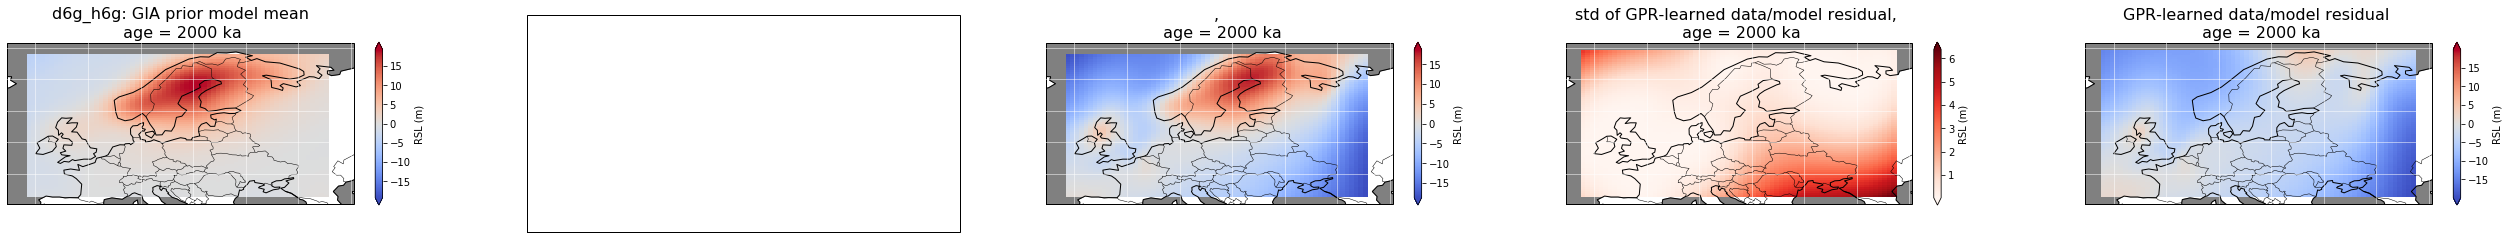

In [97]:
proj = ccrs.PlateCarree()

ages = [12000, 8500, 5500, 2000]
cbar_kwargs = {'shrink': 0.3,'label':'RSL (m)'}
vmin=-100
vmax=100
vmin_var = -0.1
vmax_var = 10
fontsize=16

def make_ax(num):
    ax[num].coastlines(resolution='110m', linewidth=1, zorder=2)
    ax[num].add_feature(cfeature.OCEAN, color='gray', zorder=0)
    ax[num].add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
    ax[num].gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

for i, age in enumerate(ages):
    
    fig, ax = plt.subplots(1, 5, figsize=(45, 10), subplot_kw=dict(projection=proj))
    ax=ax.flatten()
    
    make_ax(0)
    ds_glacprior.rsl.sel(age=age).plot(ax=ax[0], cmap='coolwarm', #norm=MidpointNormalize(vmin, vmax, 0),
                                                          cbar_kwargs=cbar_kwargs, extend='both')
    ax[0].set_title(f'{ice_model[0][:-1]}: GIA prior model mean\n age = {age} ka', fontsize=fontsize)
    
#     make_ax(1)
#     ds_glacprior.rsl.std(dim='model').sel(age=age).plot(ax=ax[1],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both',
#                                                          )
#     ax[1].set_title(f'{ice_model[:-1]}: GIA prior model std \n age = {age} ka', fontsize=fontsize)
    
       
    make_ax(2)
    ds_glacpost.rsl.sel(age=age).plot(ax=ax[2],cmap='coolwarm', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[2].set_title(f', \n age = {age} ka', fontsize=fontsize)
    
    make_ax(3)
    ds_glacvar.rsl.sel(age=age).plot(ax=ax[3],cmap='Reds', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[3].set_title(f'std of GPR-learned data/model residual, \n age = {age} ka', fontsize=fontsize)
    
    make_ax(4)
    ds_glaczp.rsl.sel(age=age).plot(ax=ax[4],cmap='coolwarm', cbar_kwargs=cbar_kwargs, extend='both',
                                                         )
    ax[4].set_title(f'GPR-learned data/model residual \n age = {age} ka', fontsize=fontsize)